# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import zlib

# Data load

In [2]:
qing_cheng_model_name = 'Qing-Cheng'
vallen_model_name = 'Vallen'

In [3]:
def get_file_paths(path: str) -> list:
    file_paths = []

    for dir_path, _, file_names in os.walk(path):
        for file_name in file_names:
            file_path = os.path.join(dir_path, file_name)
            file_paths.append(file_path)

    return file_paths

In [4]:
def mount_file_paths(sensor_name: str) -> dict:
    return {
        'Normalidade': get_file_paths(f'../data/{sensor_name}/normalidade'),
        'Normalidade-Anomalia': get_file_paths(f'../data/{sensor_name}/normalidade_anomalia'),
        'Normalidade-Spray': get_file_paths(f'../data/{sensor_name}/normalidade_spray'),
        
        'Vazamento': get_file_paths(f'../data/{sensor_name}/vazamento_5_bar'),
        'Vazamento-Anomalia': get_file_paths(f'../data/{sensor_name}/vazamento_5_bar_anomalia'),
        'Vazamento-Spray': get_file_paths(f'../data/{sensor_name}/vazamento_5_bar_spray'),
    }

In [5]:
qing_cheng_data_paths = mount_file_paths('qing_cheng')
vallen_data_paths = mount_file_paths('vallen')

In [6]:
def load_npy_file(compressed_file_path: str, position_1, position_2, state):
    # Lê o arquivo comprimido
    with open(compressed_file_path, 'rb') as compressed_file:
        compressed_data = compressed_file.read()

    # Descomprime os dados
    decompressed_data = zlib.decompress(compressed_data)

    # Converte os dados descomprimidos em um array NumPy
    decompressed_array = np.frombuffer(decompressed_data, dtype=np.float64)

    # Supondo que os dados estão organizados em dois canais alternadamente
    channel_1 = decompressed_array[::2]  # Pega todos os elementos nos índices pares
    channel_2 = decompressed_array[1::2]  # Pega todos os elementos nos índices ímpares

    # DataFrame Pandas com os dados dos canais
    data = {
        'posicao_canal_1': position_1,
        'valor_canal_1': channel_1,
        'posicao_canal_2': position_2,
        'valor_canal_2': channel_2,
        'estado': state,
    }

    df = pd.DataFrame(data)

    return df

In [7]:
def mount_data_frames(paths: list[str]):
  data_frame_dict = {}

  for path in paths:
    file_name = path.split('/')[-1]
    data_info = file_name.split('-')[:4]
    # data_info[0] -> Tipo de sensor
    # data_info[1] -> Estado
    # data_info[2] e data_info[3] -> Canal & Posição

    state = data_info[1]
    channel_1 = data_info[2].split('_')[-1]
    channel_2 = data_info[3].split('_')[-1]

    # DF -> | POSICAO_CANAL_1 | POSICAO_VALOR_1 | POSICAO_CANAL_2 | POSICAO_VALOR_2 | ESTADO |
    df = load_npy_file(path, channel_1, channel_2, state)
    data_frame_dict[channel_2] = df

  return data_frame_dict

In [8]:
def mount_data_frame_dict(data_path: dict) -> dict:
    data_frame_dict = {}
    
    for data_type, paths in data_path.items():
        data_frame_dict[data_type] = mount_data_frames(paths)
        
    return data_frame_dict

In [9]:
qing_cheng_data = mount_data_frame_dict(qing_cheng_data_paths)

In [10]:
vallen_data = mount_data_frame_dict(vallen_data_paths)

# Plot

In [11]:
def plot_raw_data(df: pd.DataFrame, title: str, position: str, sensor_name: str):
    plt.figure(figsize=(10, 6))
    
    plt.plot(df.index, df['valor_canal_1'], label='Canal 1')
    plt.plot(df.index, df['valor_canal_2'], label='Canal 2')
    
    plt.xlabel('Amostras')
    plt.ylabel('Magnitude (V)')
    plt.title(f'{sensor_name} - {title}: Posição {position}')
    
    plt.legend()
    plt.show()

## Qing-Cheng

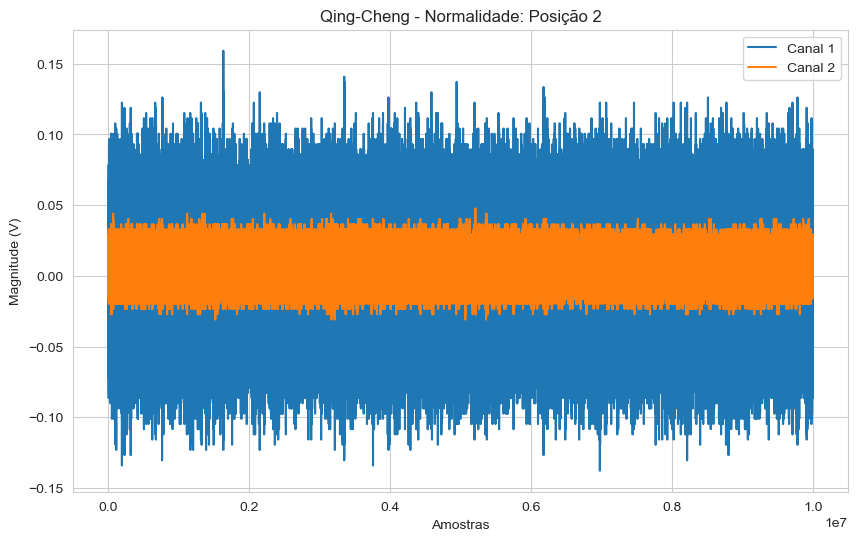

C:\Users\luka_\miniconda3\envs\gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


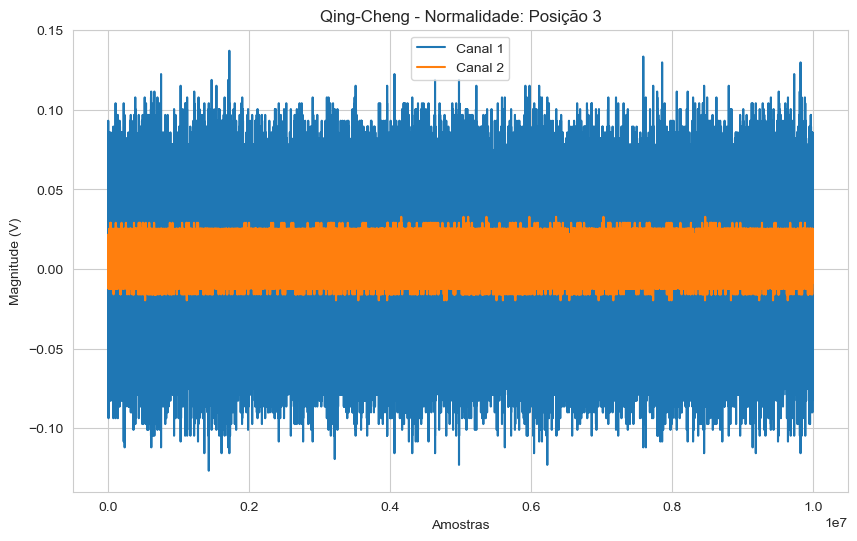

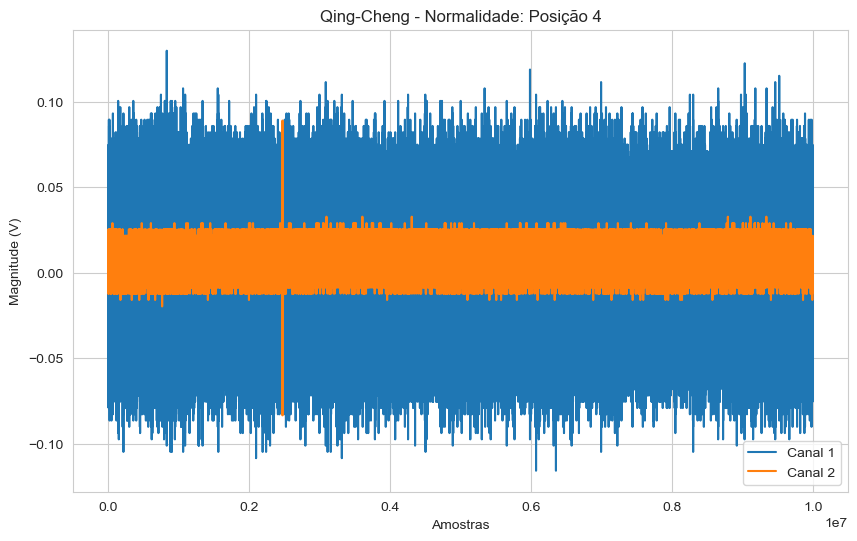

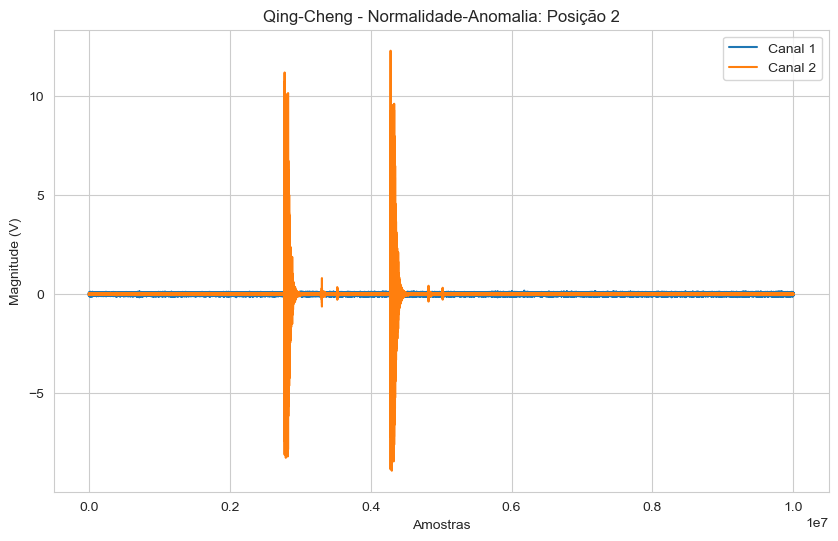

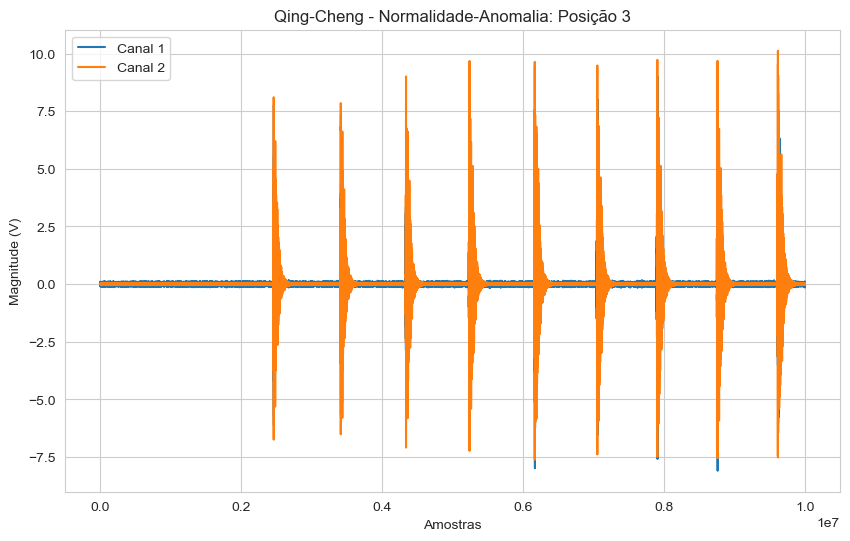

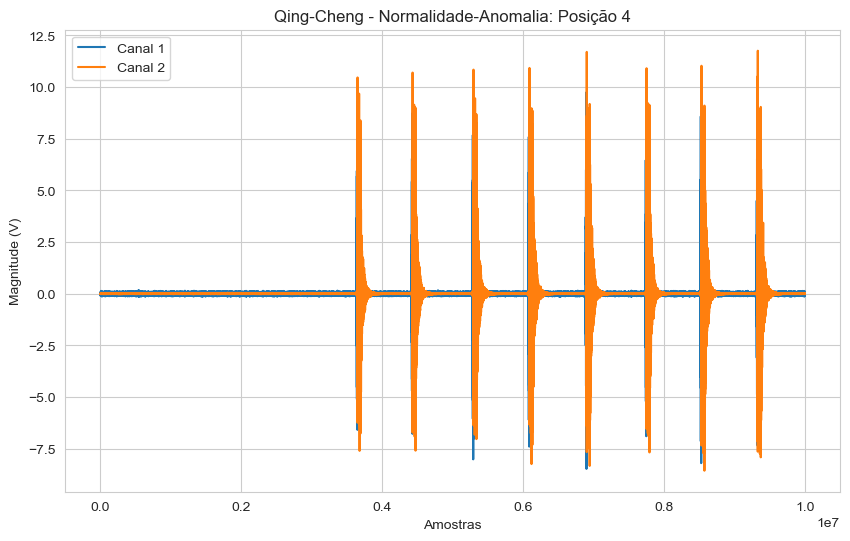

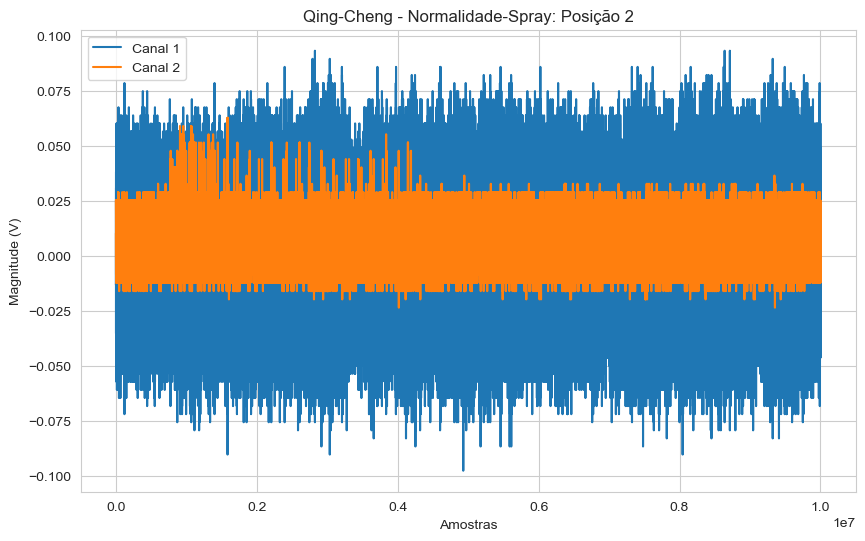

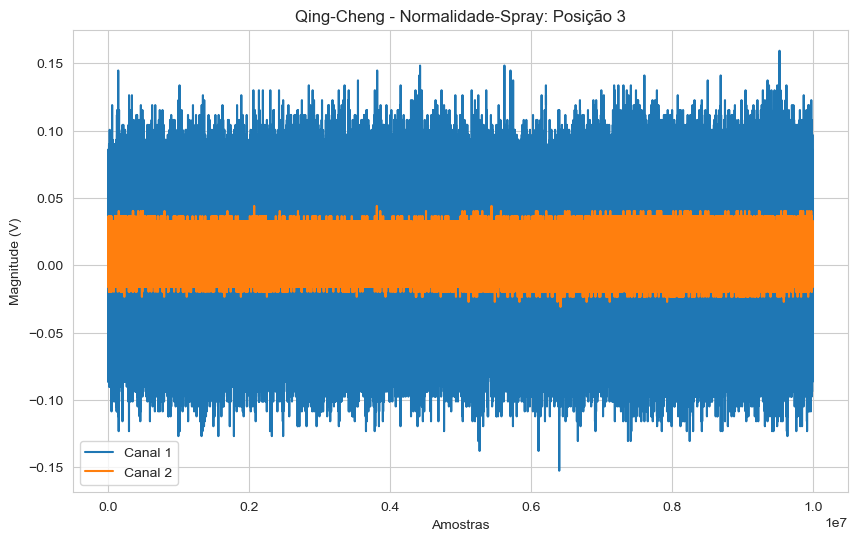

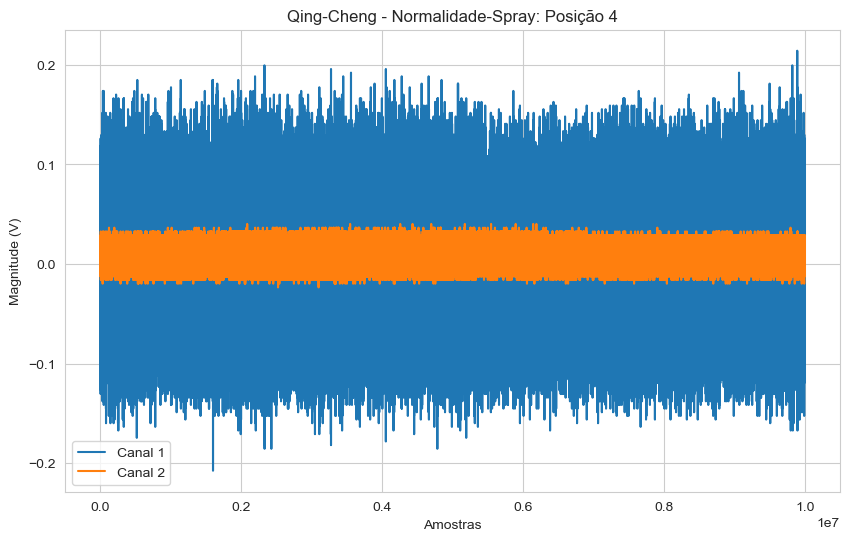

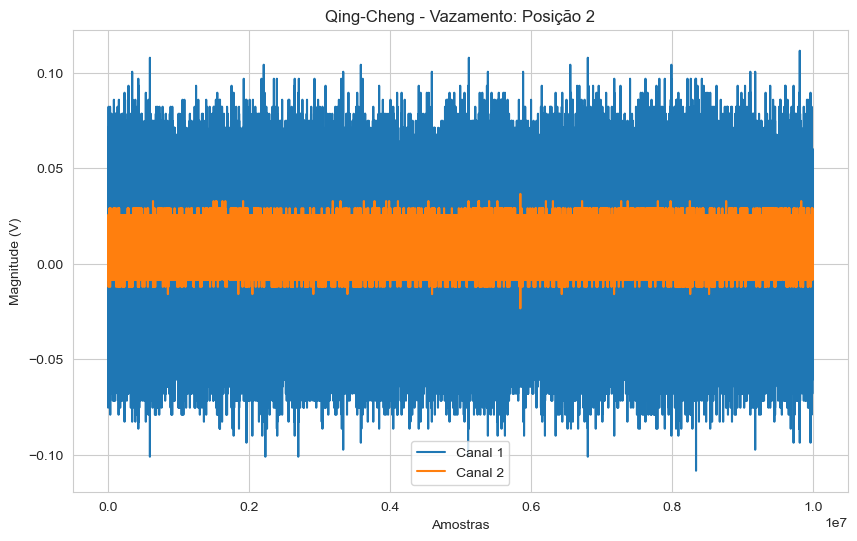

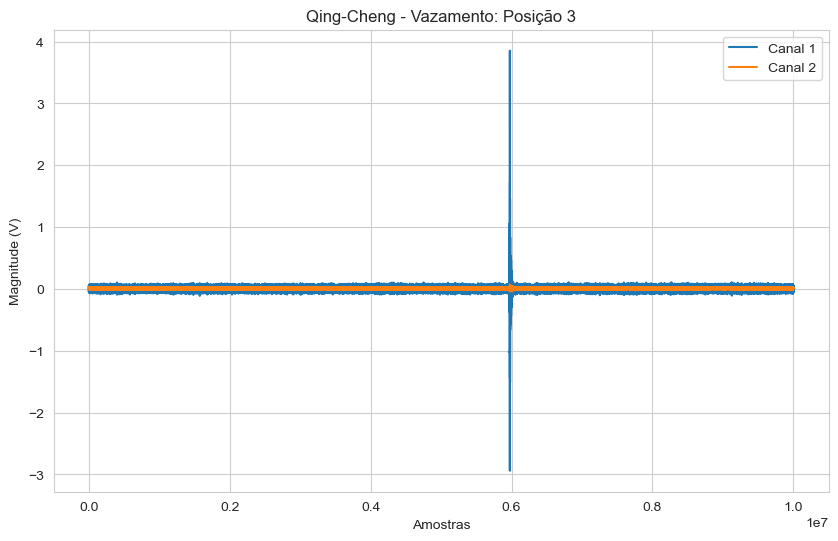

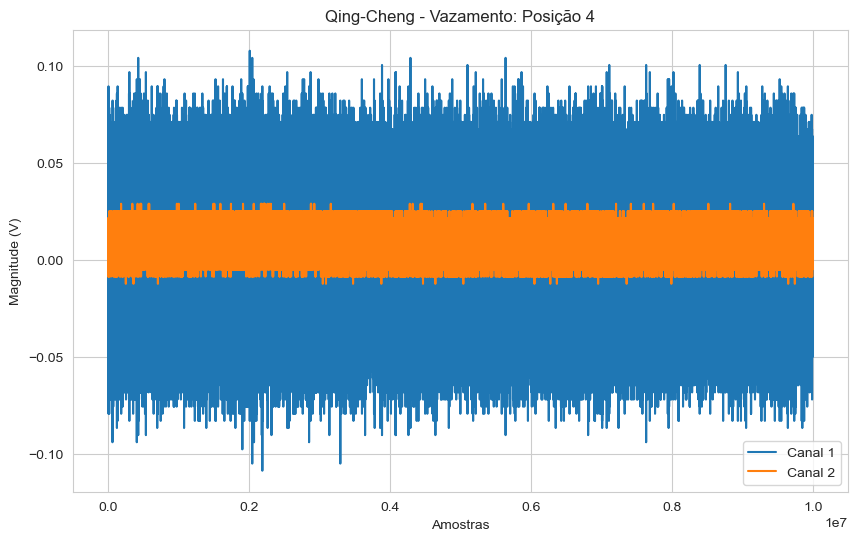

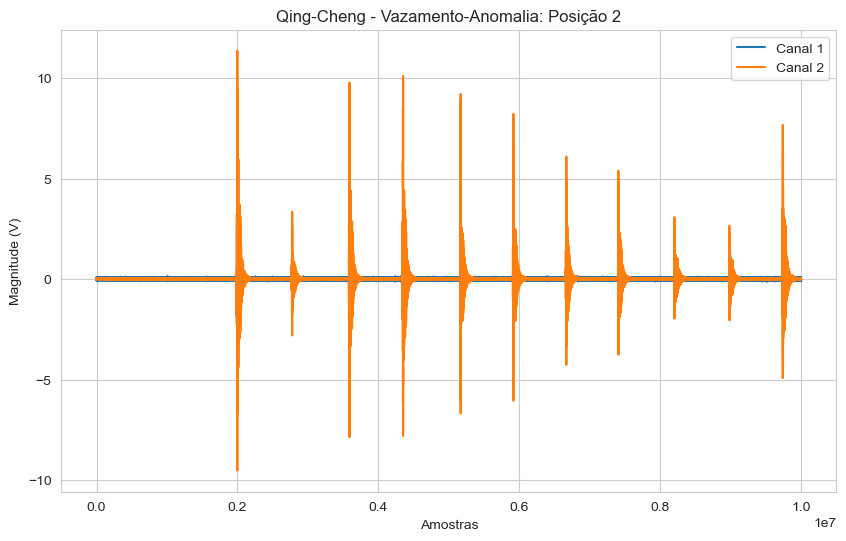

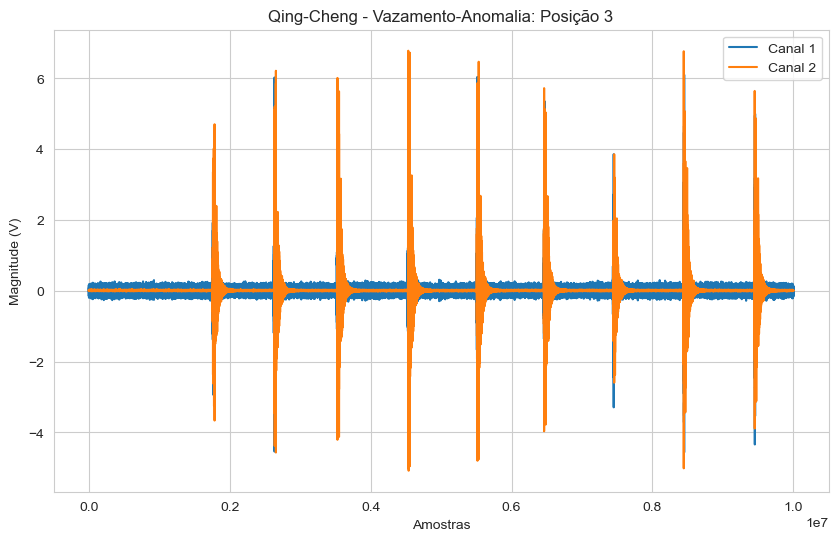

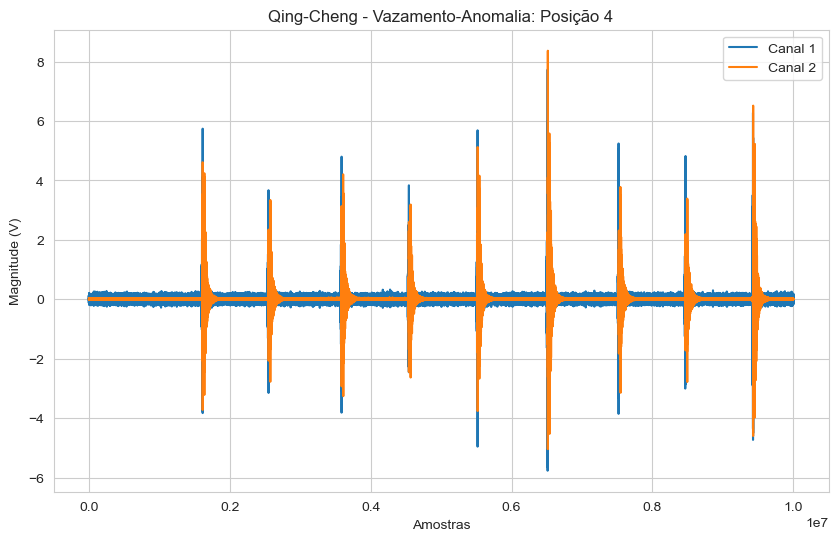

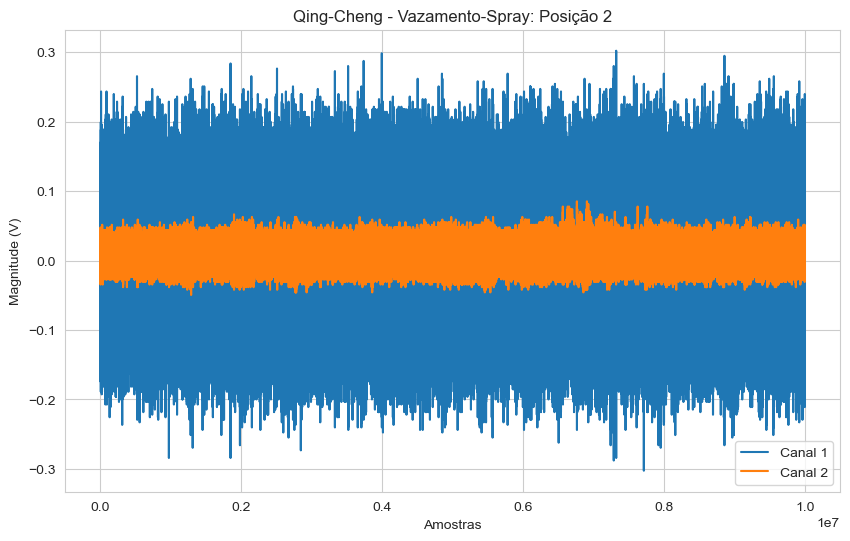

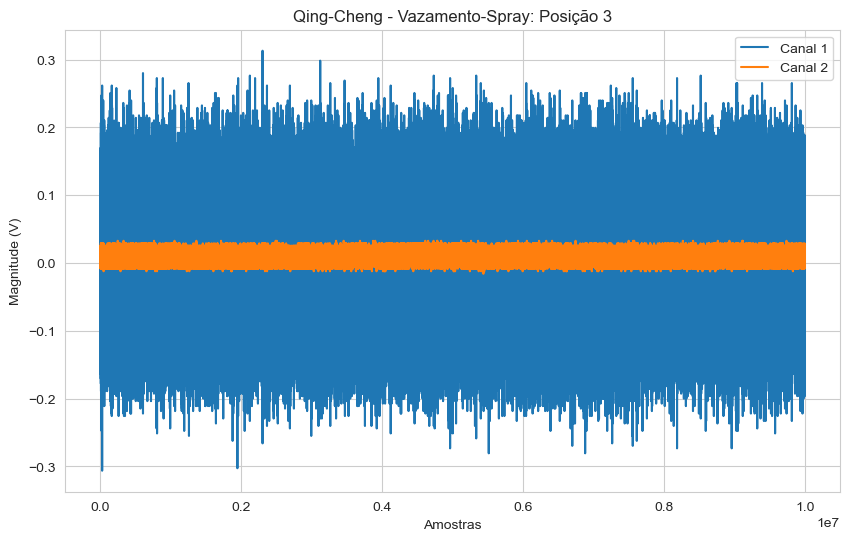

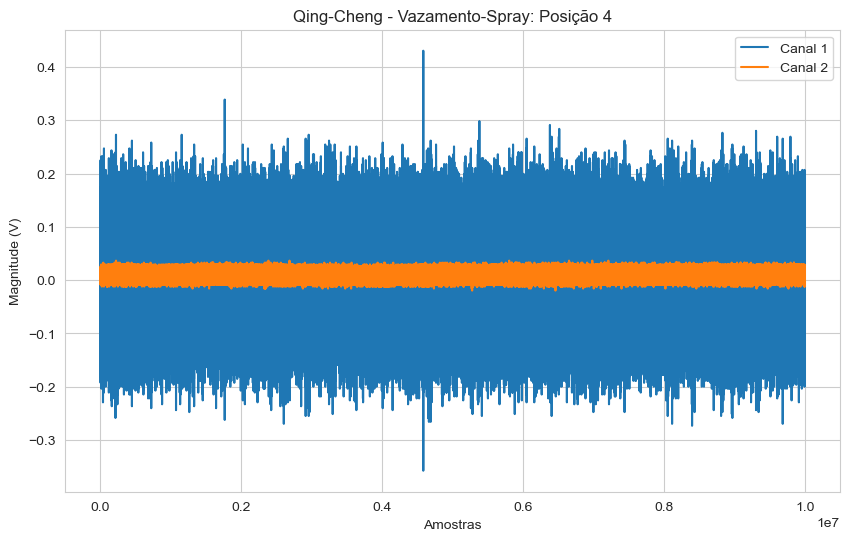

In [12]:
for data_type, data_frames in qing_cheng_data.items():
    for position, data_frame in data_frames.items():
        plot_raw_data(data_frame, data_type, position, qing_cheng_model_name)

# Vallen

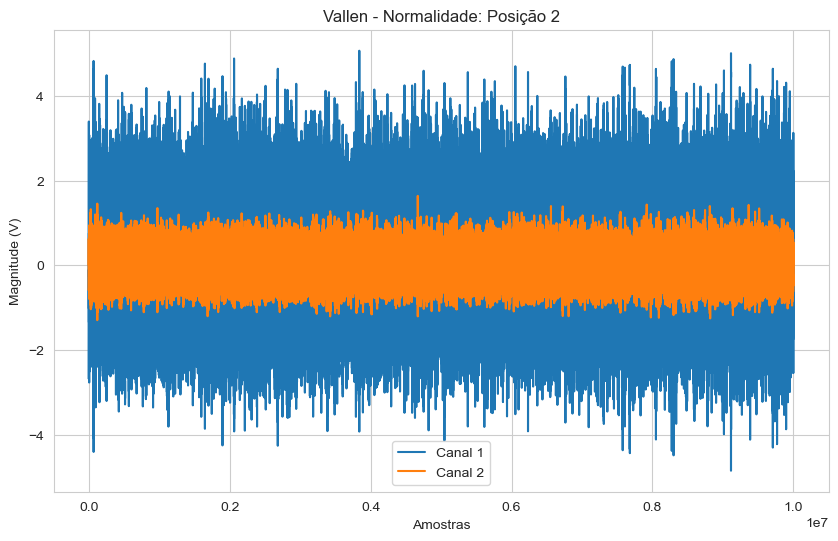

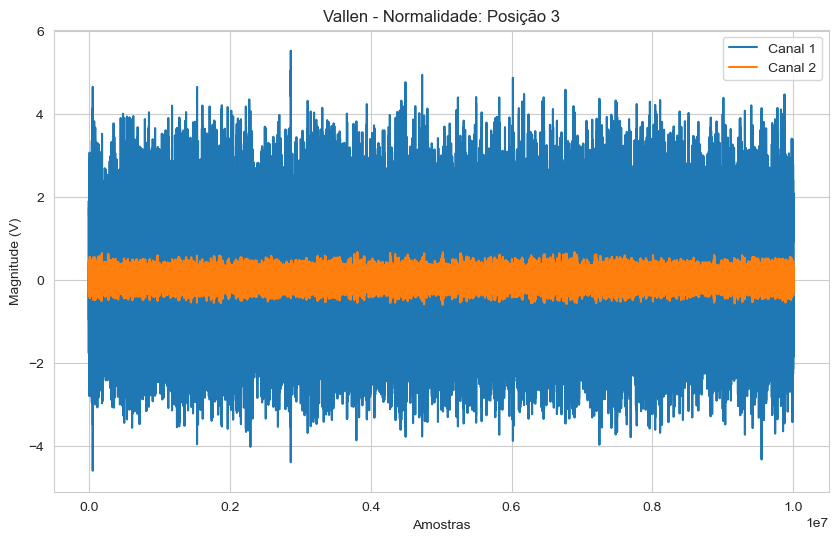

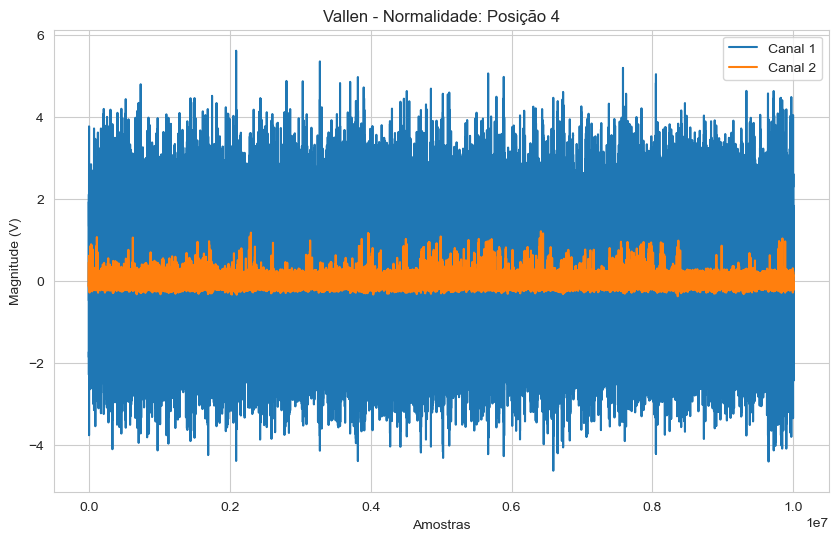

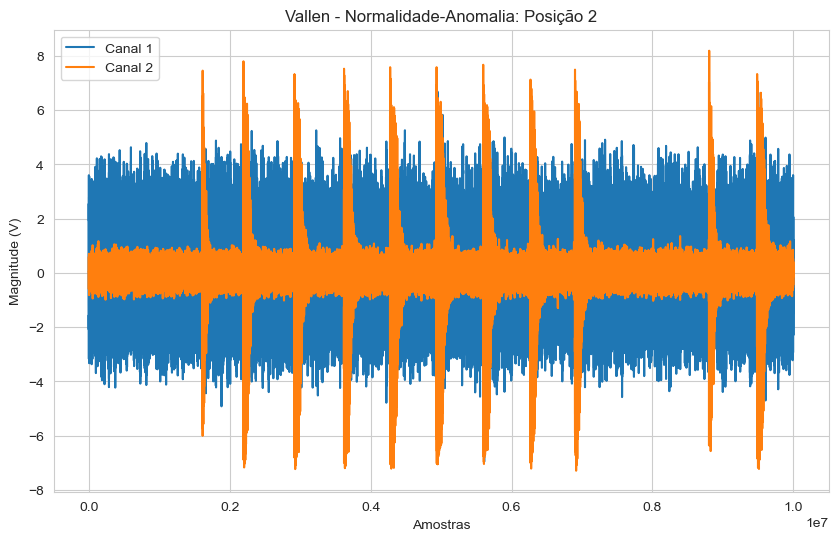

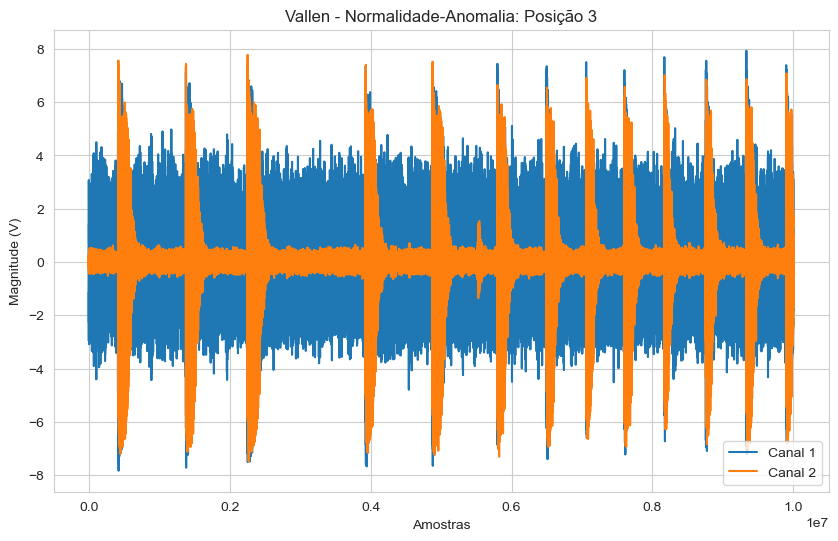

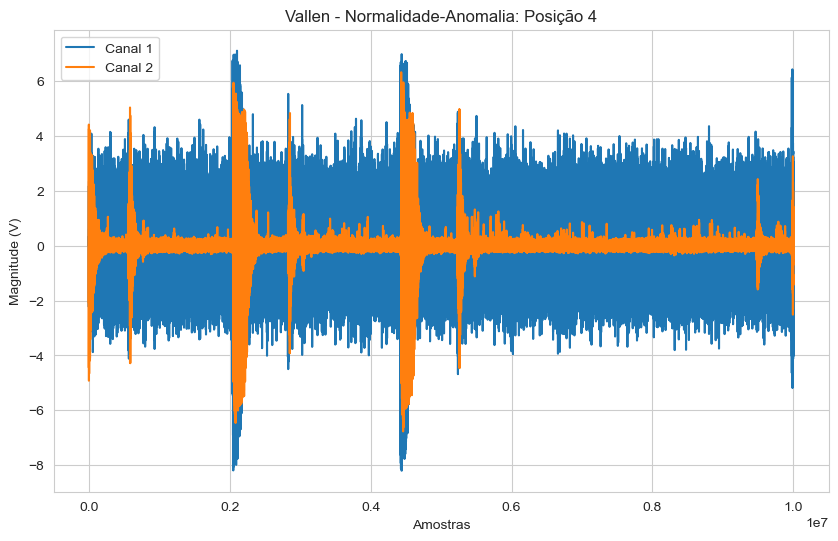

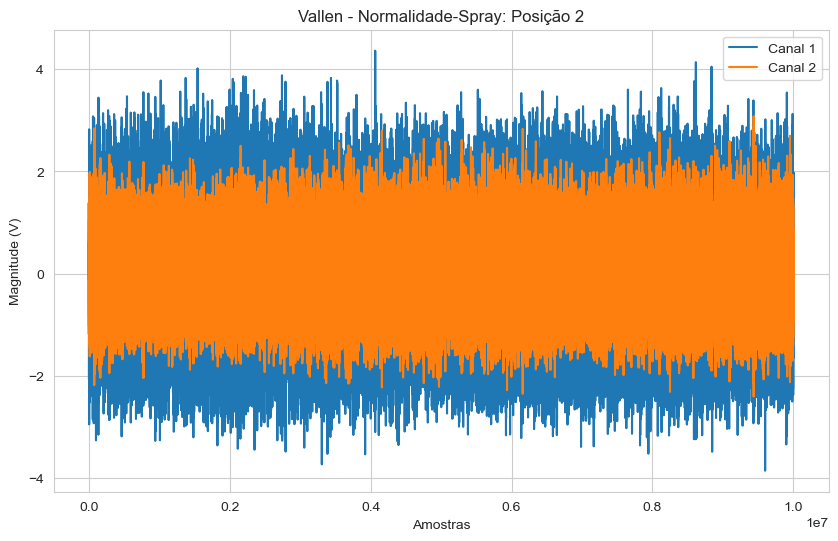

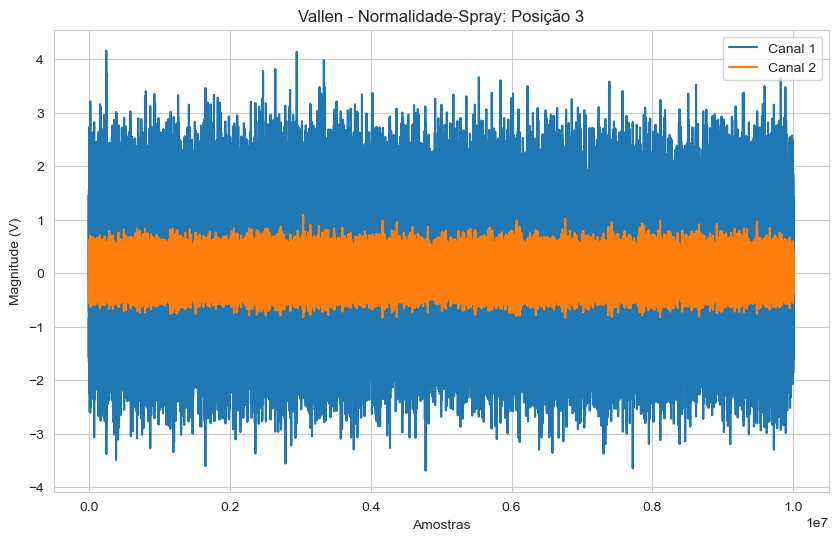

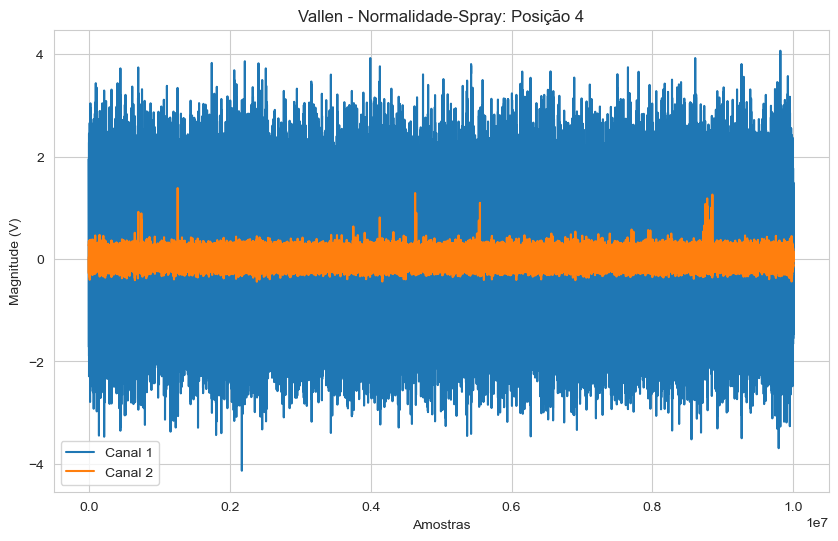

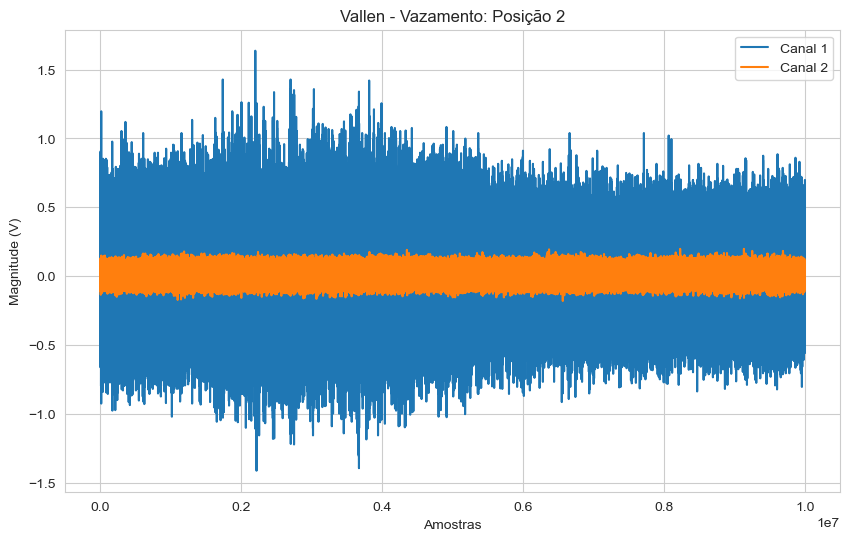

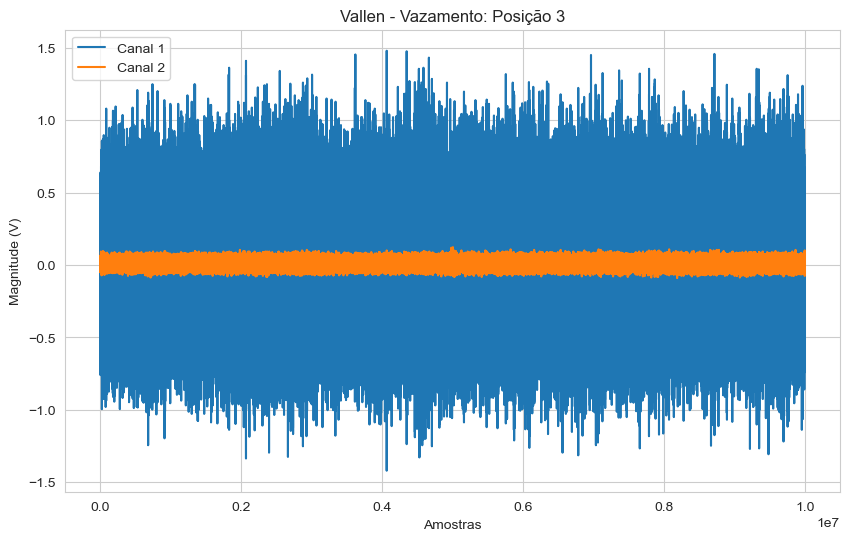

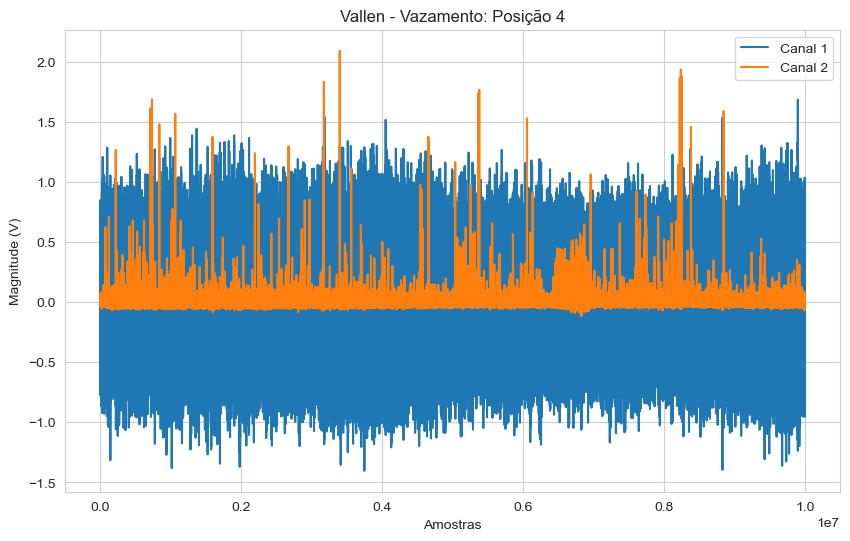

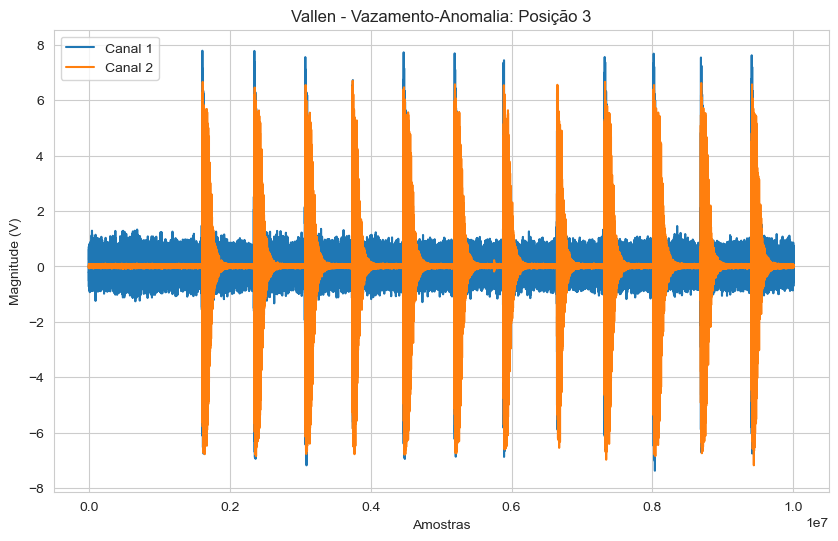

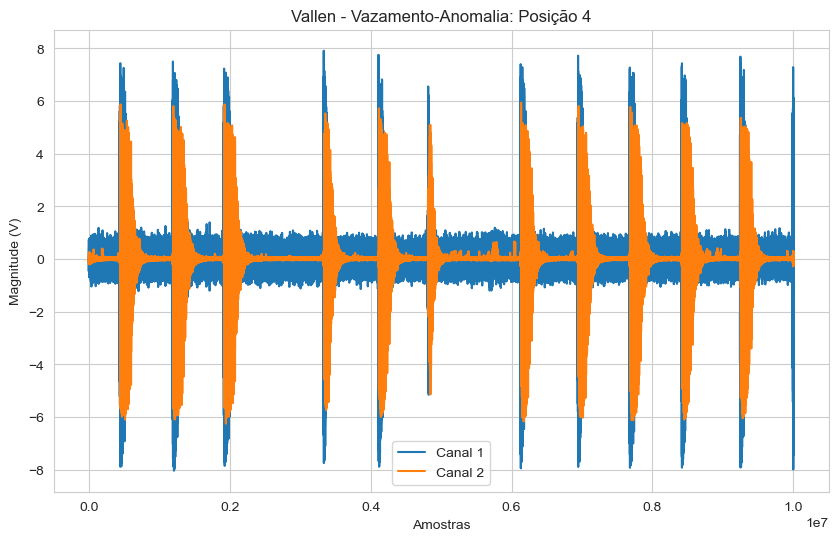

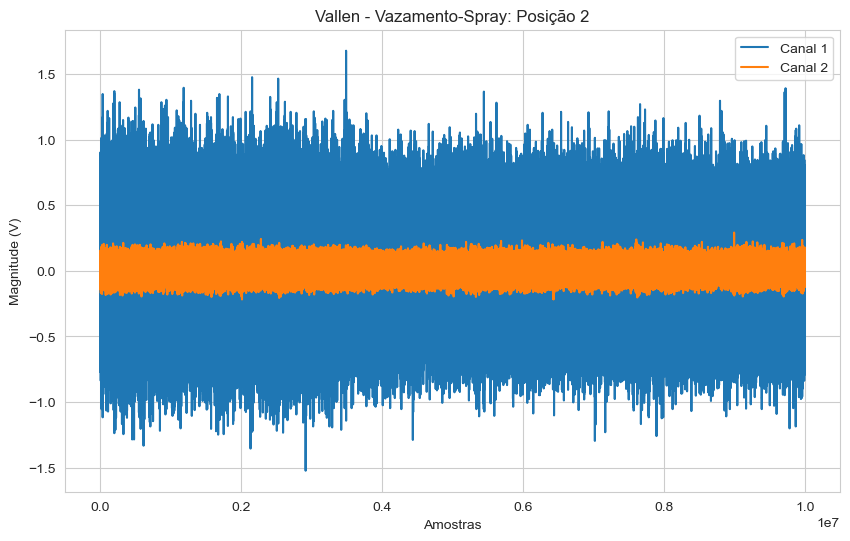

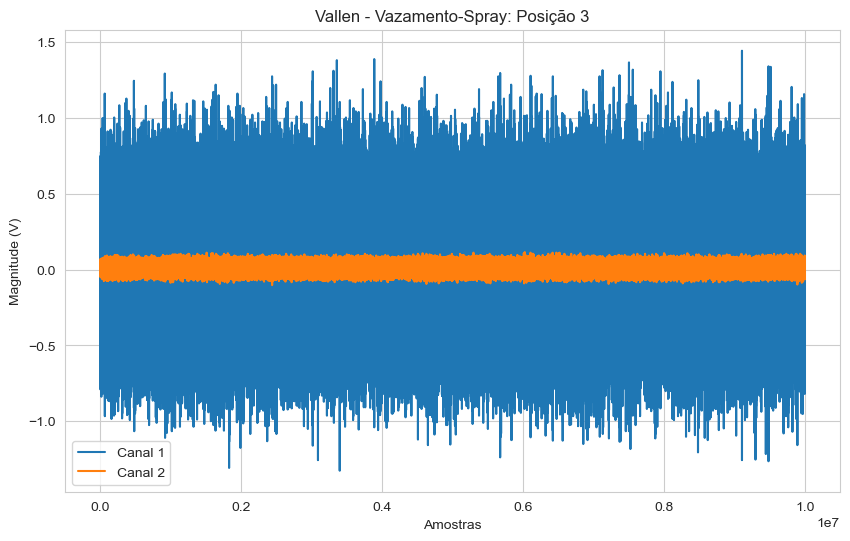

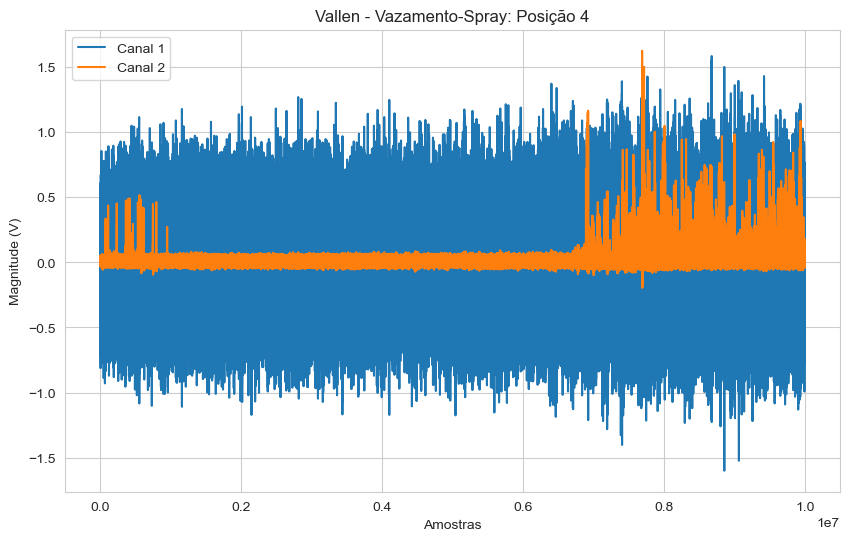

In [13]:
for data_type, data_frames in vallen_data.items():
    for position, data_frame in data_frames.items():
        plot_raw_data(data_frame, data_type, position, vallen_model_name)

# Overlapping

In [39]:
def plot_overlapping_raw_data(df_a: pd.DataFrame, df_b: pd.DataFrame,title: str, position: str, sensor_name_a: str, sensor_name_b: str):
    plt.figure(figsize=(10, 6))
    
    plt.plot(df_a.index, df_a['valor_canal_1'], label=f'{sensor_name_a} - Canal 1')
    plt.plot(df_a.index, df_a['valor_canal_2'], label=f'{sensor_name_a} - Canal 2')
    
    plt.plot(df_b.index, df_b['valor_canal_1'], label=f'{sensor_name_b} - Canal 1')
    plt.plot(df_b.index, df_b['valor_canal_2'], label=f'{sensor_name_b} - Canal 2')
    
    plt.xlabel('Amostras')
    plt.ylabel('Magnitude (V)')
    plt.title(f'{title}: Posição {position}')
    
    plt.legend(loc='upper right')
    plt.show()

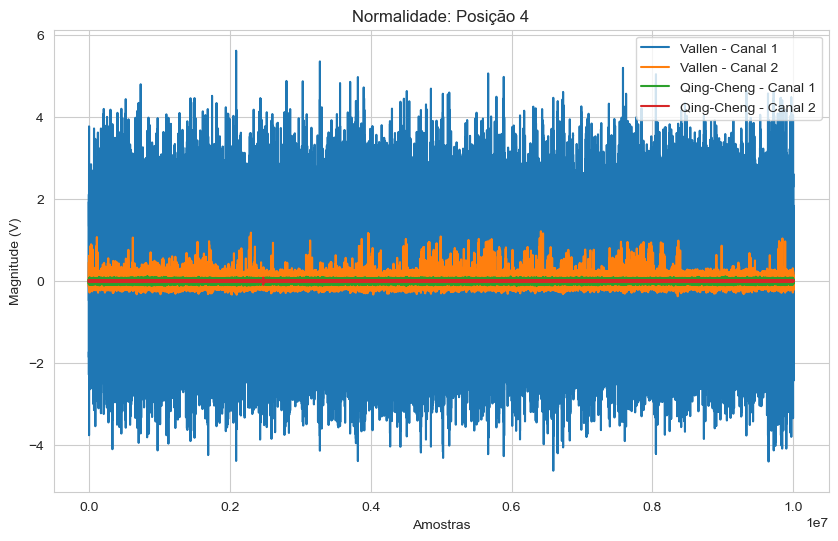

In [40]:
title='Normalidade'
position='4'

plot_overlapping_raw_data(
    df_a=vallen_data[title][position],
    sensor_name_a=vallen_model_name,
    df_b=qing_cheng_data[title][position],
    sensor_name_b=qing_cheng_model_name,
    title=title,
    position=position,
)

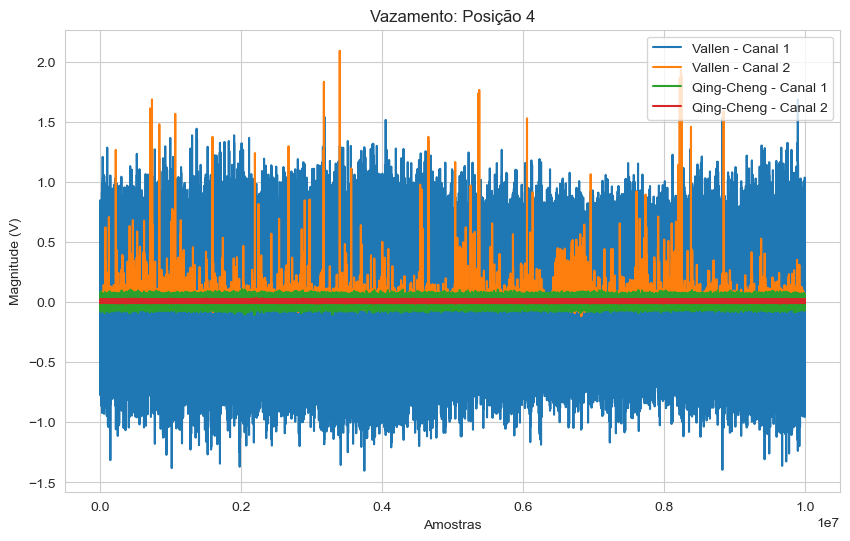

In [41]:
title='Vazamento'
position='4'

plot_overlapping_raw_data(
    df_a=vallen_data[title][position],
    sensor_name_a=vallen_model_name,
    df_b=qing_cheng_data[title][position],
    sensor_name_b=qing_cheng_model_name,
    title=title,
    position=position,
)

# Overlapping all positions

In [70]:
def plot_overlapping_all_position_raw_data(df_dict: dict, title: str, sensor_name: str):
    plt.figure(figsize=(10, 6))
    
    position='2'
    df = df_dict[title][position]
    plt.plot(df.index, df['valor_canal_1'], label=f'Posição: {position} - Canal 1')
    plt.plot(df.index, df['valor_canal_2'], label=f'Posição: {position} - Canal 2')
    
    position='3'
    df = df_dict[title][position]
    # plt.plot(df.index, df['valor_canal_1'], label=f'{sensor_name} - Canal 1')
    plt.plot(df.index, df['valor_canal_2'], label=f'Posição: {position} - Canal 2')
    
    position='4'
    df = df_dict[title][position]
    # plt.plot(df.index, df['valor_canal_1'], label=f'{sensor_name} - Canal 1')
    plt.plot(df.index, df['valor_canal_2'], label=f'Posição: {position} - Canal 2')
    
    plt.xlabel('Amostras')
    plt.ylabel('Magnitude (V)')
    plt.title(f'{sensor_name} - {title}')
    
    plt.legend(loc='upper right')
    plt.show()

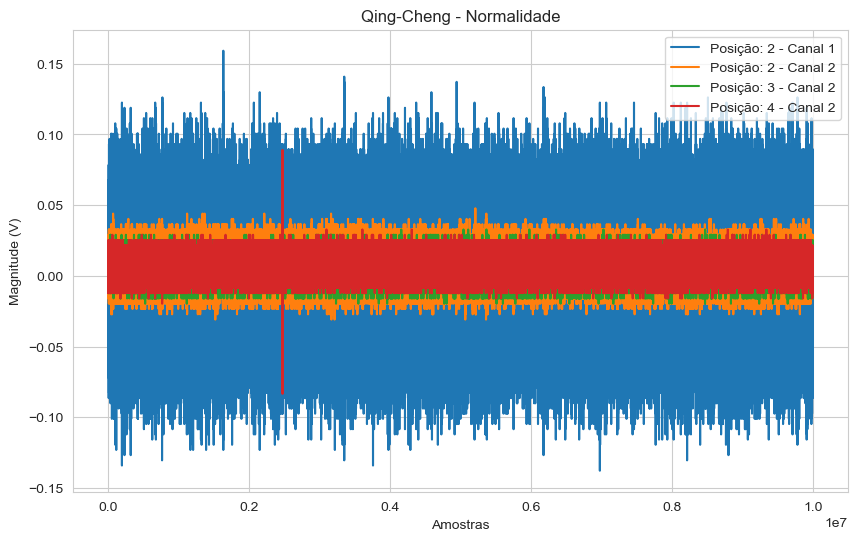

In [71]:
title='Normalidade'

plot_overlapping_all_position_raw_data(
    df_dict=qing_cheng_data,
    sensor_name=qing_cheng_model_name,
    title=title
)

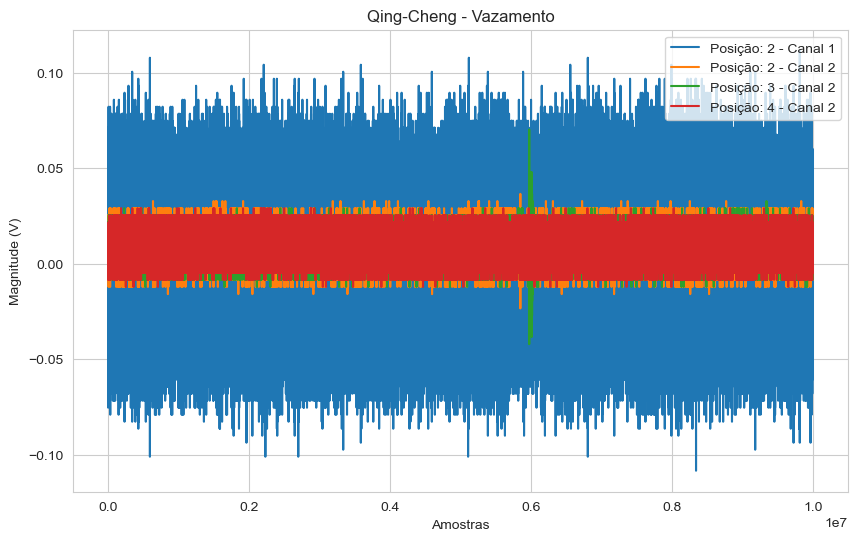

In [65]:
title='Vazamento'

plot_overlapping_all_position_raw_data(
    df_dict=qing_cheng_data,
    sensor_name=qing_cheng_model_name,
    title=title
)

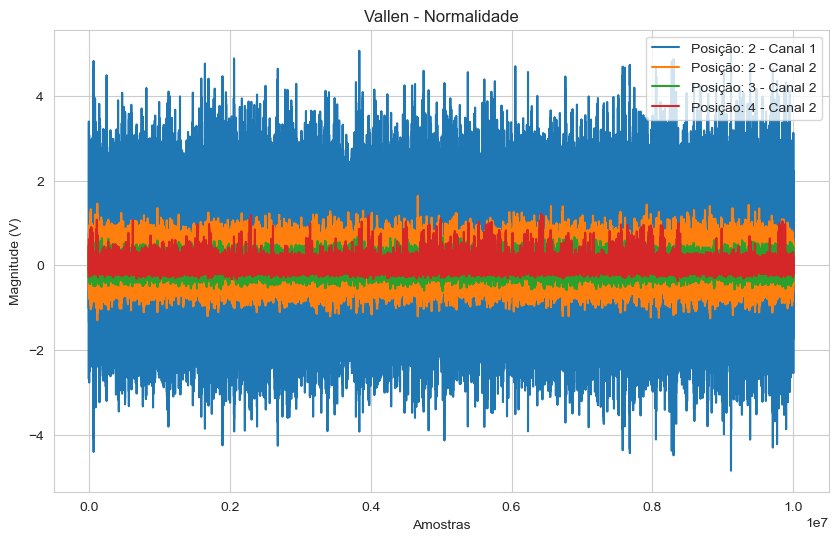

In [66]:
title='Normalidade'

plot_overlapping_all_position_raw_data(
    df_dict=vallen_data,
    sensor_name=vallen_model_name,
    title=title
)

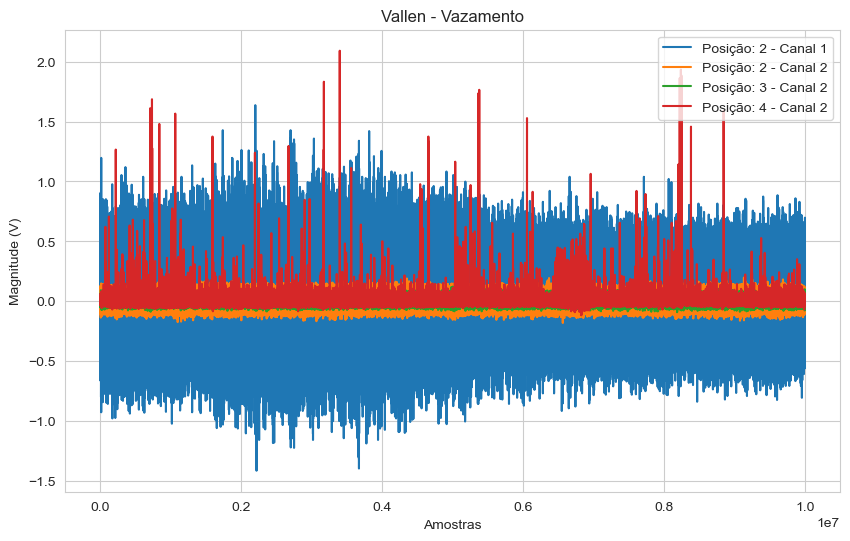

In [67]:
title='Vazamento'

plot_overlapping_all_position_raw_data(
    df_dict=vallen_data,
    sensor_name=vallen_model_name,
    title=title
)